# Waste Classification using CNN
This notebook loads and processes images for waste classification using a Convolutional Neural Network (CNN).

In [2]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import logging
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


In [ ]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import logging
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


In [3]:

# Paths
train_path = "dataset/TRAIN"
test_path = "dataset/TEST"

# Hyperparameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 0.001


In [4]:

# Function to load and preprocess images
def load_data(data_path, img_size=IMG_SIZE):
    x_data, y_data = [], []
    for category in glob(os.path.join(data_path, "*")):
        label = os.path.basename(category)
        for file in tqdm(glob(os.path.join(category, "*")), desc=f"Processing {label}"):
            try:
                img_array = cv2.imread(file)
                if img_array is None:
                    logging.warning(f"Unable to load image {file}")
                    continue
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                img_array = cv2.resize(img_array, img_size)
                x_data.append(img_array)
                y_data.append(label)
            except Exception as e:
                logging.error(f"Error processing {file}: {e}")
    
    x_data = np.array(x_data)
    y_data = pd.get_dummies(y_data).values  # One-hot encode labels
    
    return shuffle(x_data, y_data, random_state=42)


In [5]:

# Load training data
logging.info("Loading training data...")
x_train, y_train = load_data(train_path)


2025-02-08 20:26:16,163 - INFO - Loading training data...
Processing R: 100%|██████████| 9999/9999 [00:49<00:00, 202.87it/s]


Shape of y_train: (22564, 2)
First 5 rows of y_train: [[ True False]
 [ True False]
 [ True False]
 [ True False]
 [ True False]]
Labels: ['Class_0', 'Class_1']
Label counts: Class_0    12565
Class_1     9999
dtype: int64


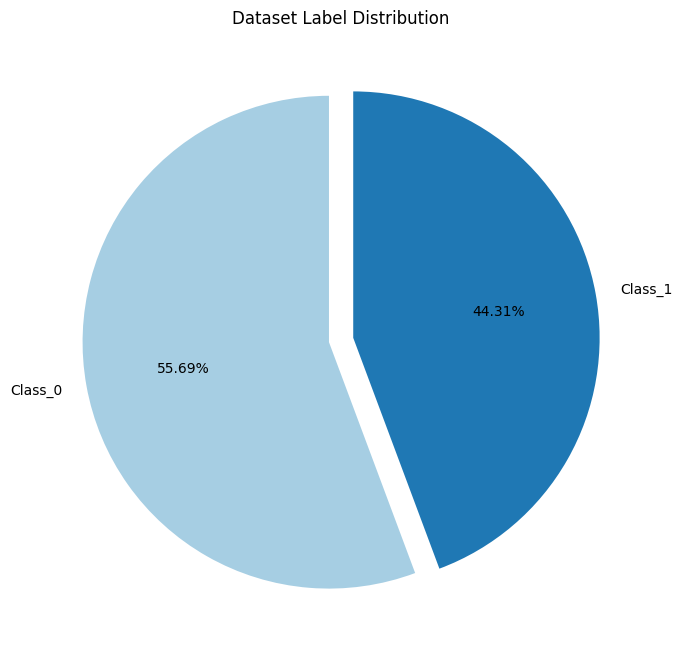

In [6]:
# Debugging y_train
print("Shape of y_train:", y_train.shape)
print("First 5 rows of y_train:", y_train[:5])

# Ensure labels are correctly defined
labels = [f"Class_{i}" for i in range(y_train.shape[1])]
print("Labels:", labels)

# Calculate label distribution
label_counts = pd.DataFrame(y_train, columns=labels).sum()
print("Label counts:", label_counts)

# Plot pie chart for label distribution
plt.figure(figsize=(8, 8))
plt.pie(
    label_counts,
    labels=labels,
    autopct='%0.2f%%',
    colors=plt.cm.Paired.colors[:len(labels)],
    startangle=90,
    explode=[0.05] * len(labels)
)
plt.title("Dataset Label Distribution")
plt.show()


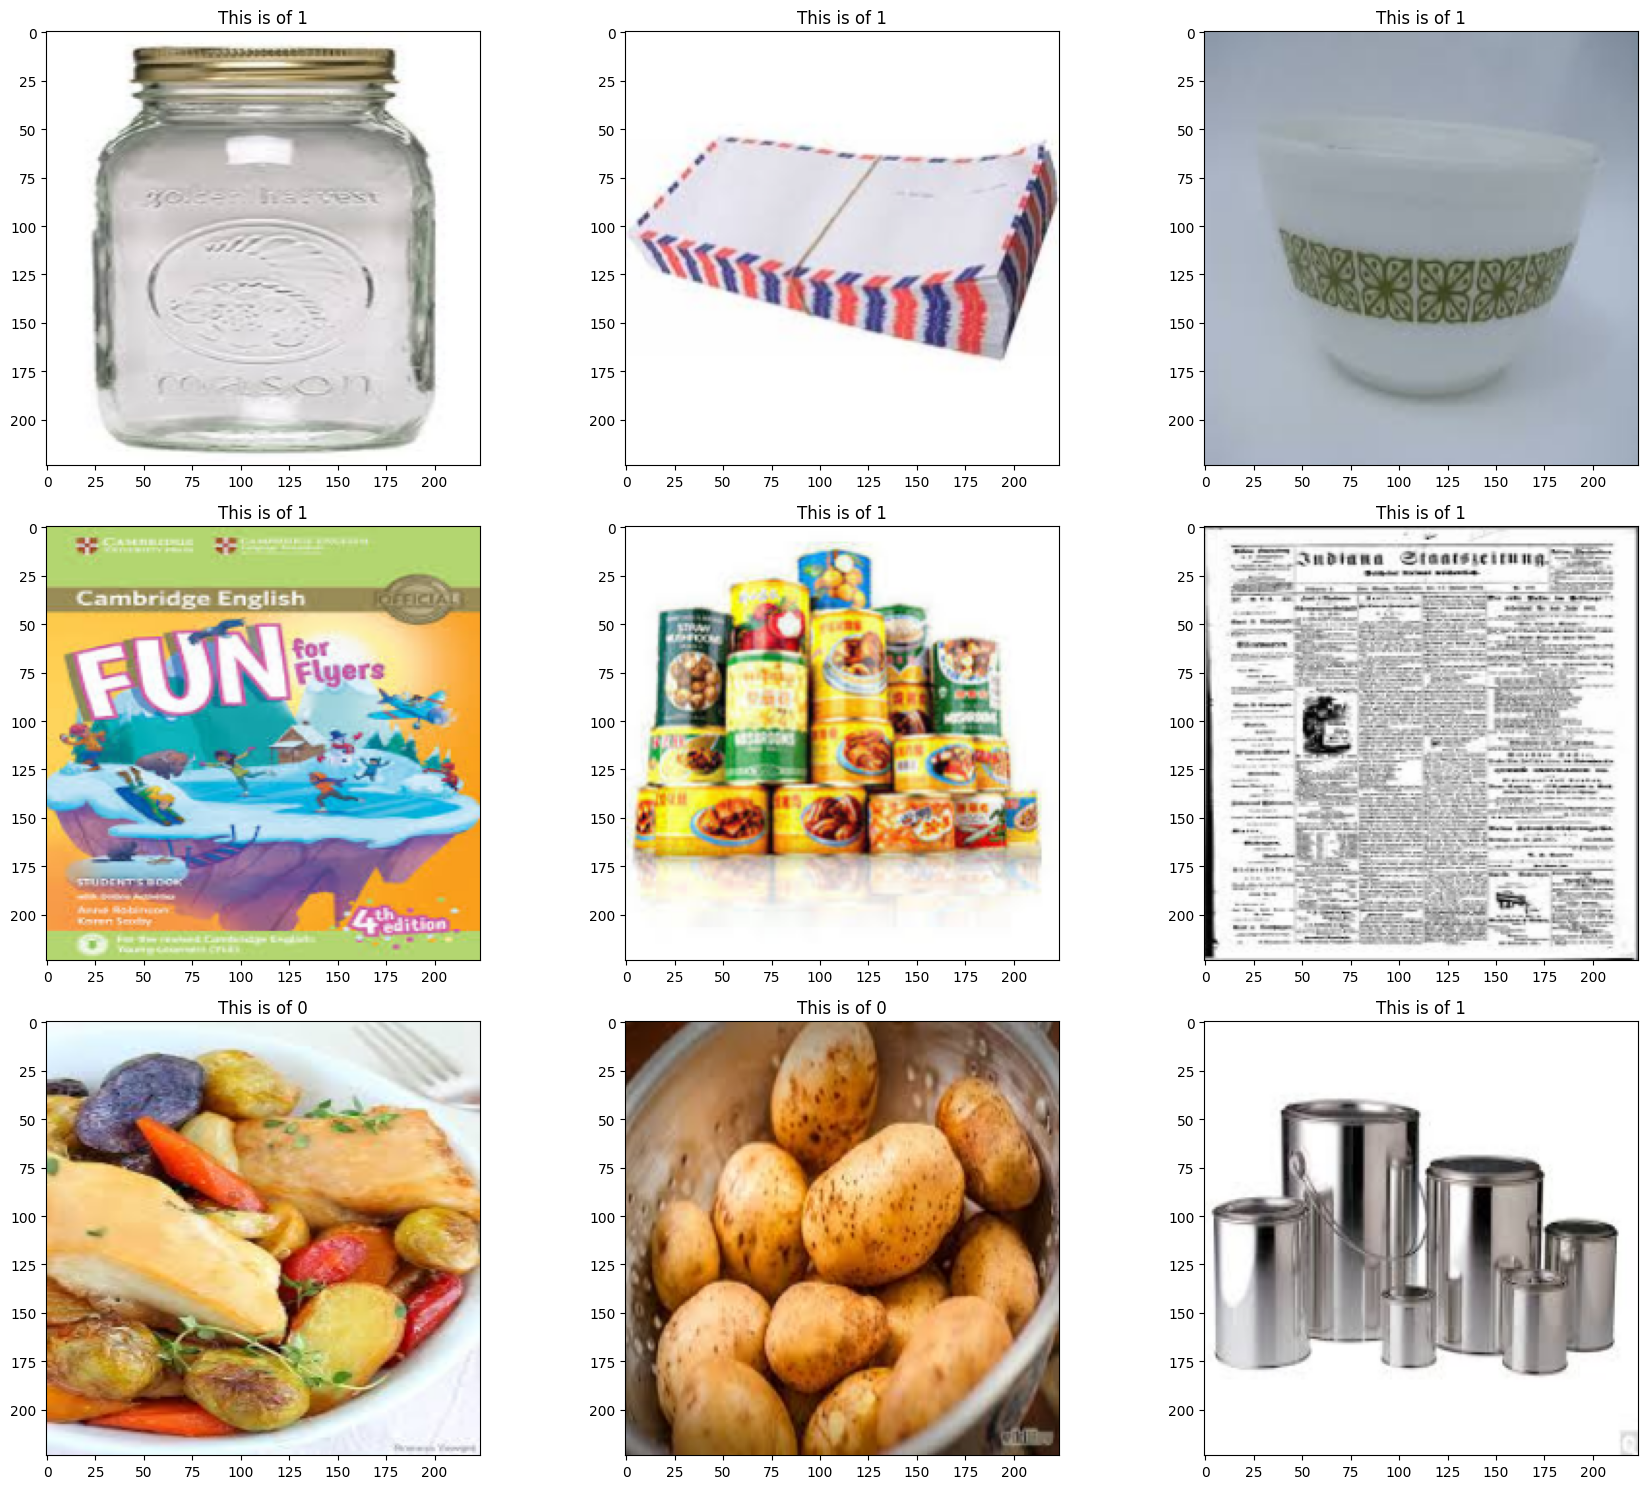

In [7]:
# Plot some random images from the dataset
plt.figure(figsize=(20, 15))
for i in range(9):
    plt.subplot(3, 3, i+1)  # Changed to subplot grid of 3x3
    index = np.random.randint(len(x_train))
    plt.title('This is of {0}'.format(np.argmax(y_train[index])))
    plt.imshow(x_train[index])
    plt.tight_layout()
plt.show()


In [8]:

# Image Data Generators with Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)

train_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE, subset="training")
val_generator = val_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE, subset="validation")


In [9]:

# Function to build the CNN model
def build_model(input_shape=IMG_SIZE + (3,), num_classes=len(labels)):
    model = Sequential([
        Conv2D(32, (3, 3), padding="same", input_shape=input_shape),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(),

        Conv2D(64, (3, 3), padding="same"),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(),

        Conv2D(128, (3, 3), padding="same"),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=LEARNING_RATE), metrics=["accuracy"])
    return model


In [10]:

# Build and summarize the model
logging.info("Building the model...")
model = build_model()
model.summary()


2025-02-08 20:29:39,407 - INFO - Building the model...


c:\Users\chebo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,785,026 (98.36 MB)

 Trainable params: 25,784,578 (98.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [11]:

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

# Train the model
logging.info("Training the model...")
history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks)


2025-02-08 20:29:43,639 - INFO - Training the model...
c:\Users\chebo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7317 - loss: 6.0159

2025-02-08 20:51:41,287 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


565/565 ━━━━━━━━━━━━━━━━━━━━ 1317s 2s/step - accuracy: 0.7317 - loss: 6.0083 - val_accuracy: 0.8183 - val_loss: 0.4241 - learning_rate: 0.0010
Epoch 2/5
565/565 ━━━━━━━━━━━━━━━━━━━━ 1312s 2s/step - accuracy: 0.7605 - loss: 0.5001 - val_accuracy: 0.8258 - val_loss: 0.4336 - learning_rate: 0.0010
Epoch 3/5
565/565 ━━━━━━━━━━━━━━━━━━━━ 2295s 4s/step - accuracy: 0.7607 - loss: 0.5022 - val_accuracy: 0.8149 - val_loss: 0.4249 - learning_rate: 0.0010
Epoch 4/5
565/565 ━━━━━━━━━━━━━━━━━━━━ 1313s 2s/step - accuracy: 0.7560 - loss: 0.5066 - val_accuracy: 0.8502 - val_loss: 0.4835 - learning_rate: 0.0010
Epoch 5/5
565/565 ━━━━━━━━━━━━━━━━━━━━ 2888s 5s/step - accuracy: 0.7815 - loss: 0.5333 - val_accuracy: 0.8451 - val_loss: 0.4581 - learning_rate: 2.0000e-04


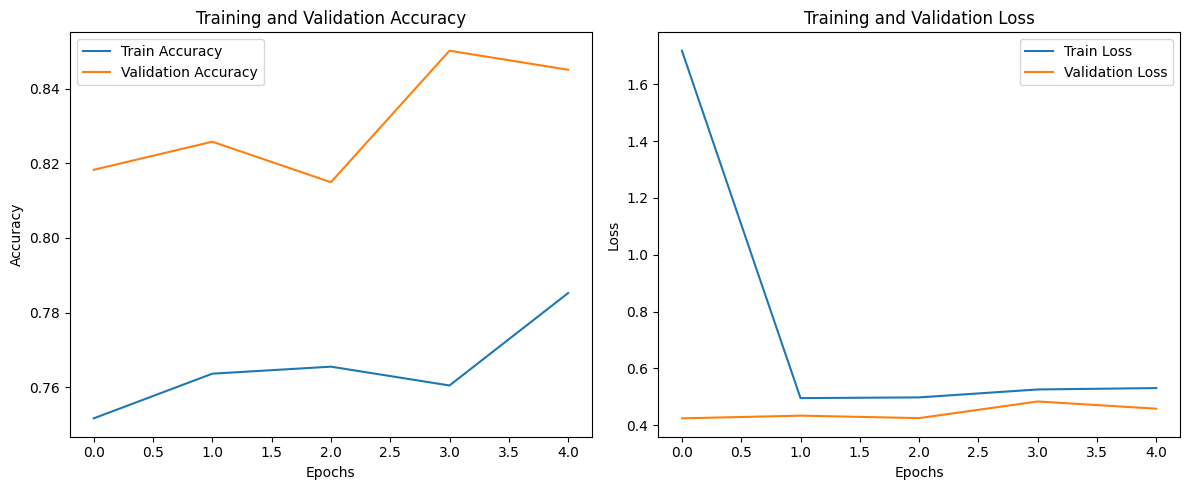

In [12]:

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()


In [13]:

# Evaluate on test data (if available)
if os.path.exists(test_path):
    logging.info("Loading test data...")
    x_test, y_test = load_data(test_path)
    test_generator = val_datagen.flow(x_test, y_test, batch_size=BATCH_SIZE, shuffle=False)
    
    logging.info("Evaluating the model on test data...")
    test_loss, test_accuracy = model.evaluate(test_generator)
    logging.info(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
else:
    logging.warning("Test directory not found. Skipping evaluation.")


2025-02-08 23:01:58,044 - INFO - Loading test data...
Processing R: 100%|██████████| 1112/1112 [00:05<00:00, 186.60it/s]
2025-02-08 23:02:13,511 - INFO - Evaluating the model on test data...
c:\Users\chebo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 316ms/step - accuracy: 0.8449 - loss: 0.3561


2025-02-08 23:02:38,926 - INFO - Test Loss: 0.3487, Test Accuracy: 0.8499


In [22]:
def predict_fun(img):
    plt.figure(figsize=(6, 4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    img = cv2.resize(img, (224, 224))
    img = np.reshape(img, [-1, 224, 224, 3])
    prediction = model.predict(img)
    result = np.argmax(prediction)
    confidence = np.max(prediction)
    class_labels = {0: "ORGANIC", 1: "RECYCLABLE"}
    print(f"THIS IMAGE IS {class_labels[result]} with confidence {confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
THIS IMAGE IS RECYCLABLE with confidence 1.00


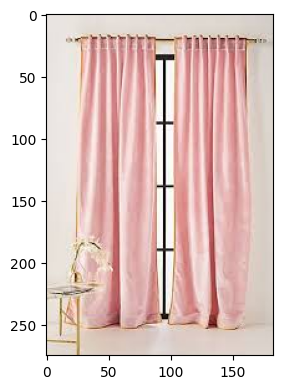

In [23]:

test_img = cv2.imread('C:\\Users\\chebo\\OneDrive\\Desktop\\Waste CLassification\\DATASET\\DATASET\\TEST\\R\\R_10060.jpg')
predict_fun(test_img)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
THIS IMAGE IS RECYCLABLE with confidence 1.00


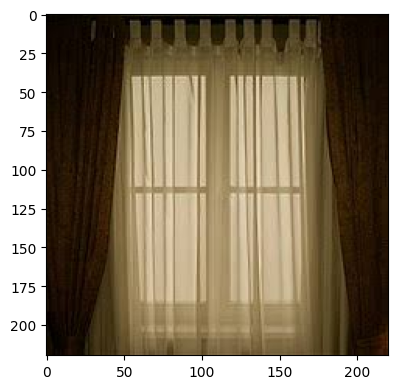

In [24]:
test_img = cv2.imread('C:\\Users\\chebo\\OneDrive\\Desktop\\Waste CLassification\\DATASET\\DATASET\\TEST\\R\\R_10089.jpg')
predict_fun(test_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
THIS IMAGE IS ORGANIC with confidence 1.00


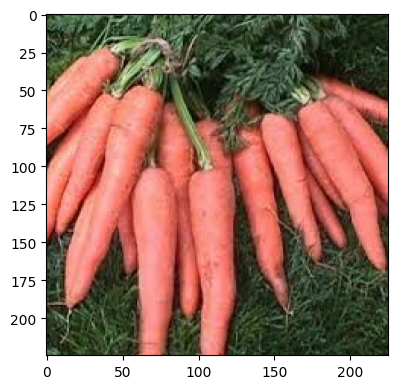

In [20]:
test_img = cv2.imread('C:\\Users\\chebo\\OneDrive\\Desktop\\Waste CLassification\\DATASET\\DATASET\\TEST\\O\\O_12666.jpg')
predict_fun(test_img)